# Fake News Detection

Fake news has become a critical issue in today's digital age, especially with the rise of social media platforms where misinformation spreads rapidly. Identifying and combating fake news is essential to maintain the integrity of information consumed by the public. In recent years, Natural Language Processing (NLP) techniques have played a significant role in detecting fake news by analyzing textual patterns and linguistic features.

State-of-the-art NLP models like BERT (Bidirectional Encoder Representations from Transformers) have proven to be highly effective in handling complex language understanding tasks. These models are pre-trained on large corpora and can be fine-tuned for specific tasks such as fake news detection. Their ability to capture the context of words in both directions (left-to-right and right-to-left) allows for deeper semantic understanding, making them ideal for detecting nuanced differences between truthful and deceptive information.

In this project, we aim to fine-tune BERT and other Transformer-based models to detect fake news accurately. By leveraging these advanced models, we hope to identify fake news more efficiently and prevent its harmful effects. Detecting and handling fake news promptly can significantly reduce the spread of misinformation, promoting a more informed and responsible society.

The use of Transformer models in this domain offers several benefits, including improved accuracy, scalability, and the ability to handle large amounts of text data. With the rapid growth of online content, implementing such models is crucial in mitigating the impact of fake news on individuals and organizations. Through this project, we will explore how fine-tuning these state-of-the-art models can enhance the detection of fake news and contribute to a more trustworthy information ecosystem.



The dataset contains two types of articles fake and real News. This dataset was collected from realworld sources; the truthful articles were obtained by crawling articles from Reuters.com (News website). As for the fake news articles, they were collected from different sources. The fake news articles were collected from unreliable websites that were flagged by Politifact (a fact-checking organization in the USA) and Wikipedia. The dataset contains different types of articles on different topics, however, the majority of articles focus on political and World news topics.

The dataset consists of two CSV files. The first file named “True.csv” contains more than 12,600 articles from reuter.com. The second file named “Fake.csv” contains more than 12,600 articles from different fake news outlet resources. Each article contains the following information: article title, text, type and the date the article was published on. To match the fake news data collected for kaggle.com, we focused mostly on collecting articles from 2016 to 2017. The data collected were cleaned and processed, however, the punctuations and mistakes that existed in the fake news were kept in the text.

We are going to use 3 transformers models and 4 traditional machine learning modles for comparision.

## Transformers Models
- BERT
- ELECTRA
- RoBERTa

## Traditional Machine Learning Models
- GaussianNB
- KNeighbors
- SGDClassifier
- Logistic Regression

In [ ]:
#from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


## Import Libraries

In [ ]:
# Install required libraries
#!pip install transformers
#!pip install nltk
#!pip install scikit-learn
#!pip install seaborn
#!pip install matplotlib

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (BertTokenizer, BertForSequenceClassification,
                          ElectraTokenizerFast, ElectraForSequenceClassification,
                          RobertaTokenizer, RobertaForSequenceClassification,
                          )
from torch.optim import AdamW  # Updated import
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# from tqdm import tqdm
from tqdm.notebook import tqdm  # Use the notebook version for better compatibility


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Loading and Preparation

In [ ]:
# Load the datasets
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')


# Add labels
true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news

# Combine datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Drop unnecessary columns
df = df.drop(columns=['date', 'subject'])



In [ ]:
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Sample data for faster execution

In [ ]:
df = df.sample(n=2000, random_state=42).reset_index(drop=True)

In [ ]:
df['label'].value_counts()

,count
label,
0,1063
1,937


## Data Shuffling and Cleaning



In [ ]:
# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove missing values
df = df.dropna()

# Define text preprocessing function
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing
df['clean_text'] = df['text'].apply(text_preprocessing)


In [ ]:
X = df['clean_text']
y = df['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Transformer Models (BERT, ELECTRA, RoBERTa)**


In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    losses = []
    progress_bar = tqdm(data_loader, desc="Training", leave=True)

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # Update tqdm progress bar with loss
        progress_bar.set_postfix({'loss': loss.item()})

    return np.mean(losses)


In [ ]:
def eval_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, probabilities)

    return accuracy, roc_auc, f1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
model_names = ['ELECTRA', 'RoBERTa', 'BERT']
results_transformer = []

for model_name in model_names:
    print(f'\nTraining {model_name} model...')

    if model_name == 'RoBERTa':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        model = RobertaForSequenceClassification.from_pretrained('roberta-base')
    elif model_name == 'ELECTRA':
        tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')
        model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator')
    elif model_name == 'BERT':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    model = model.to(device)

    # Create datasets
    train_dataset = NewsDataset(X_train, y_train, tokenizer, max_len=128)
    test_dataset = NewsDataset(X_test, y_test, tokenizer, max_len=128)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Train model
    epochs = 5  # Adjust as needed
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')
        tqdm.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')  # Replaced print with tqdm.write

    # Evaluate model
    accuracy, roc_auc, f1 = eval_model(model, test_loader, device)
    # print(f'{model_name} Test Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}')
    tqdm.write(f'{model_name} Test Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}')  # Replaced print with tqdm.write

    # Store results
    results_transformer.append({
        'Model': model_name,
        'Accuracy (Test)': accuracy,
        'ROC-AUC (Test)': roc_auc,
        'F1-Score (Test)': f1
    })



Training ELECTRA model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.3605


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.0482


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.0157


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.0150


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.0165


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

ELECTRA Test Accuracy: 0.9875, ROC-AUC: 0.9991, F1-Score: 0.9868

Training RoBERTa model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.2555


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.0292


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.0148


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.0163


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.0158


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

RoBERTa Test Accuracy: 0.9925, ROC-AUC: 0.9962, F1-Score: 0.9920

Training BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.2129


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.0167


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.0152


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.0148


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.0099


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

BERT Test Accuracy: 0.9950, ROC-AUC: 0.9997, F1-Score: 0.9947


## Classification Report for Best Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
def get_predictions_and_labels(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return np.array(predictions), np.array(true_labels), np.array(probabilities)

# Get predictions and labels for BERT model
preds, labels, probs = get_predictions_and_labels(model, test_loader, device)

# Generate classification report
print("Classification Report for Best Model:")
print(classification_report(labels, preds, target_names=['Fake', 'Real']))


Classification Report for Best Model:
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00       213
        Real       0.99      1.00      0.99       187

    accuracy                           0.99       400
   macro avg       0.99      1.00      0.99       400
weighted avg       1.00      0.99      1.00       400



## Confusion Matrix for Best Model

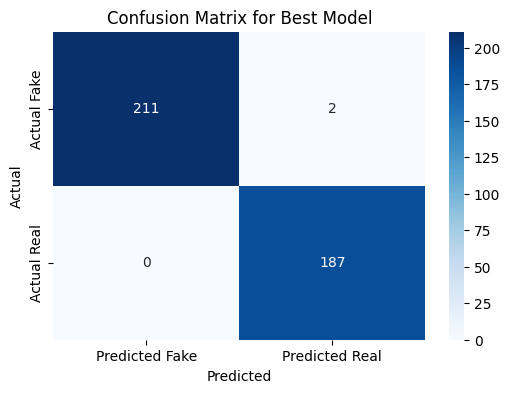

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(labels, preds)
cm_df = pd.DataFrame(cm, index=['Actual Fake', 'Actual Real'], columns=['Predicted Fake', 'Predicted Real'])

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# **Traditional Machine Learning Models [GaussianNB, LogisticRegression, SGDClassifier, KNeighbors]**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier

ml_models = {
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=1),
    'SGDClassifier': SGDClassifier(loss='log_loss', random_state=1),
    'KNeighbors': KNeighborsClassifier(),
    #'DecisionTree': DecisionTreeClassifier(random_state=1),
}

In [ ]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

results_ml = []

for model_name, model in ml_models.items():
    print(f"\nTraining and evaluating model: {model_name}")

    if model_name == 'GaussianNB':
        # GaussianNB requires dense input
        X_train_input = X_train_tfidf.toarray()
        X_test_input = X_test_tfidf.toarray()
    else:
        X_train_input = X_train_tfidf
        X_test_input = X_test_tfidf

    # Cross-validation
    cv_results = cross_validate(
        model,
        X_train_input,
        y_train,
        cv=5,
        scoring=['accuracy', 'roc_auc', 'f1'],
        n_jobs=-1,
        return_train_score=False
    )

    # Fit the model on the entire training data
    model.fit(X_train_input, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_input)
    y_proba = None
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_input)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_proba = model.decision_function(X_test_input)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    if y_proba is not None and len(np.unique(y_test)) == 2:  # Ensure binary classification
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None  # Cannot compute ROC-AUC

    # Store results
    results_ml.append({
        'Model': model_name,
        'Accuracy (Test)': accuracy,
        'ROC-AUC (Test)': roc_auc,
        'F1-Score (Test)': f1
    })

    # Print results
    print(f"{model_name} Test Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc if roc_auc is not None else 'N/A'}, F1-Score: {f1:.4f}")



Training and evaluating model: GaussianNB
GaussianNB Test Accuracy: 0.8525, ROC-AUC: 0.8602093846501468, F1-Score: 0.8375

Training and evaluating model: LogisticRegression
LogisticRegression Test Accuracy: 0.9550, ROC-AUC: 0.9912630865406342, F1-Score: 0.9519

Training and evaluating model: SGDClassifier
SGDClassifier Test Accuracy: 0.9700, ROC-AUC: 0.9950289975144988, F1-Score: 0.9683

Training and evaluating model: KNeighbors
KNeighbors Test Accuracy: 0.5550, ROC-AUC: 0.6111696919484824, F1-Score: 0.0918


In [ ]:
# Convert lists of dictionaries to DataFrames
results_df_transformer = pd.DataFrame(results_transformer)
results_df_ml = pd.DataFrame(results_ml)

# Combine the DataFrames
all_results_df = pd.concat([results_df_transformer, results_df_ml], ignore_index=True)


## **Visualizing Model Performance Comparison**

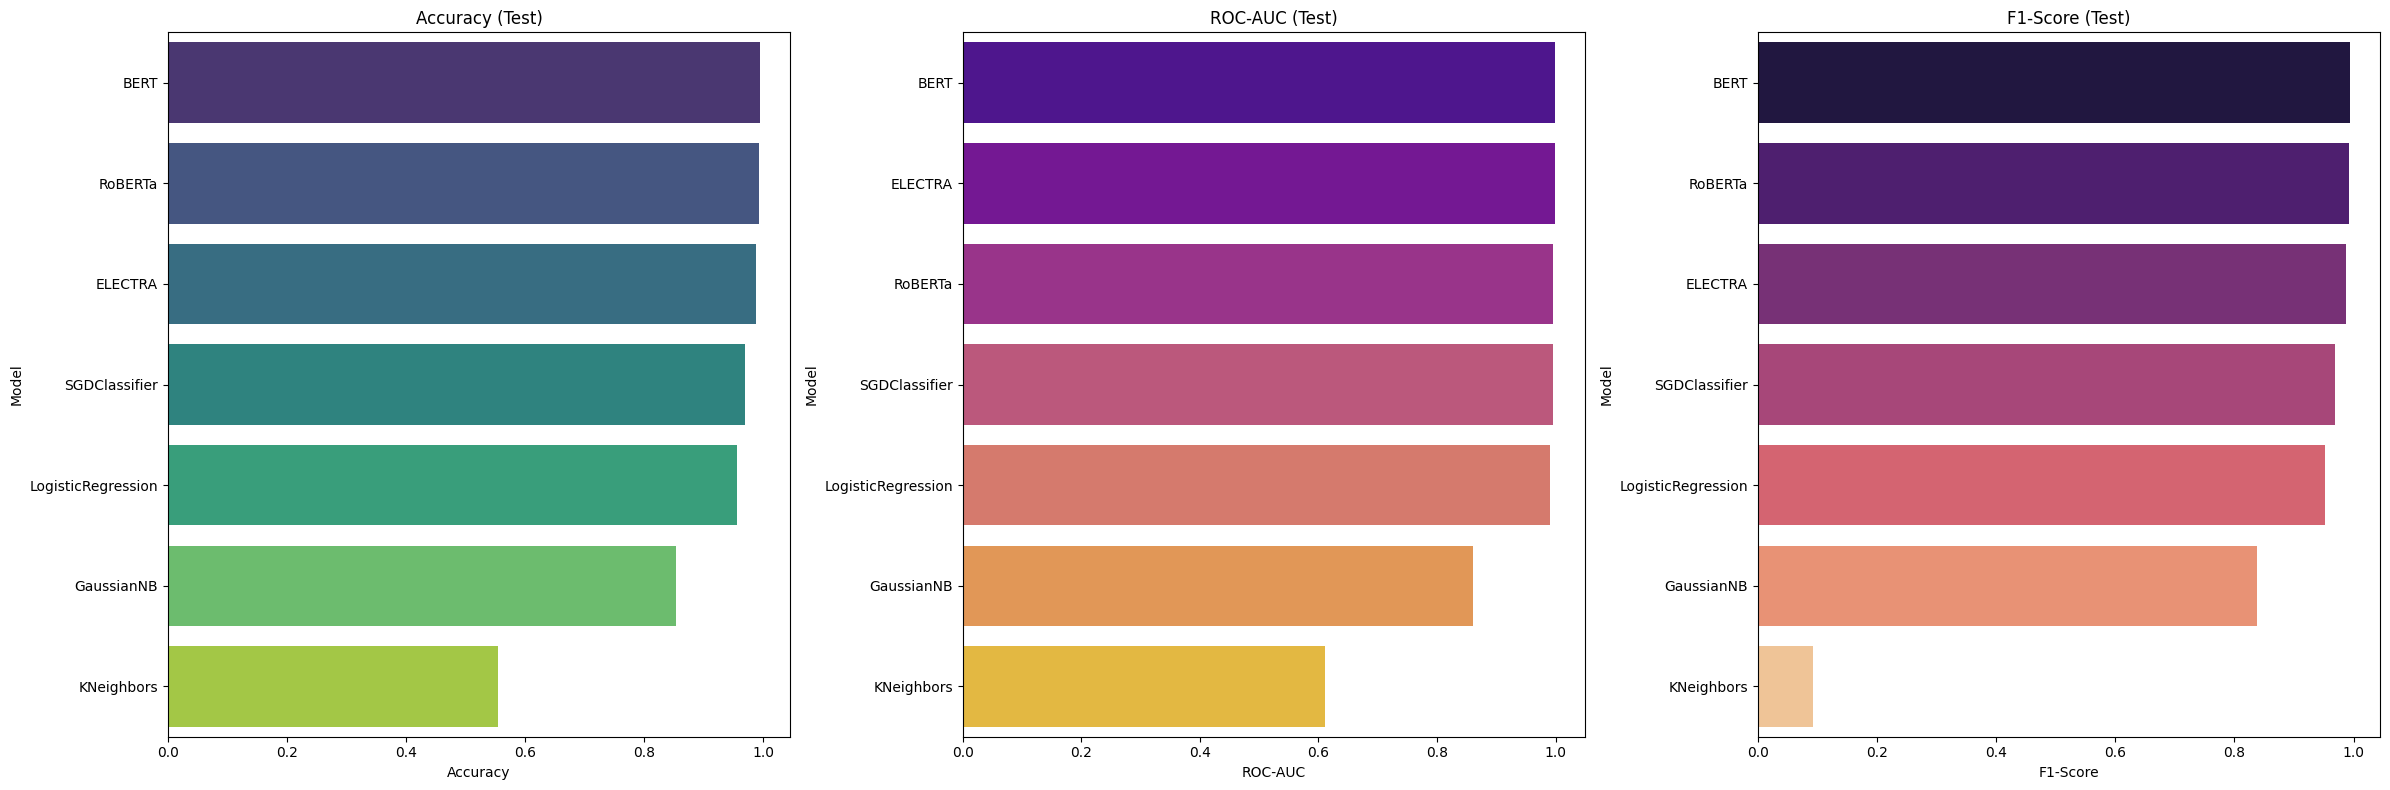

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

all_results_df = pd.concat([results_df_transformer, results_df_ml], ignore_index=True)

plt.figure(figsize=(24, 8))

# Accuracy
plt.subplot(1, 3, 1)
sns.barplot(
    x='Accuracy (Test)',
    y='Model',
    data=all_results_df.sort_values(by='Accuracy (Test)', ascending=False),
    palette='viridis',
    hue='Model',
    dodge=False
)
plt.title('Accuracy (Test)')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.legend([],[], frameon=False)
plt.tight_layout()

# ROC-AUC
plt.subplot(1, 3, 2)
sns.barplot(
    x='ROC-AUC (Test)',
    y='Model',
    data=all_results_df.sort_values(by='ROC-AUC (Test)', ascending=False),
    palette='plasma',
    hue='Model',
    dodge=False
)
plt.title('ROC-AUC (Test)')
plt.xlabel('ROC-AUC')
plt.ylabel('Model')
plt.legend([],[], frameon=False)
plt.tight_layout()

# F1-Score
plt.subplot(1, 3, 3)
sns.barplot(
    x='F1-Score (Test)',
    y='Model',
    data=all_results_df.sort_values(by='F1-Score (Test)', ascending=False),
    palette='magma',
    hue='Model',
    dodge=False
)
plt.title('F1-Score (Test)')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.legend([],[], frameon=False)
plt.tight_layout()

plt.show()
